# Model Fitting

## Imports etc...

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import helpers as h

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 10,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
    "lines.linewidth" : 0.8,
    "lines.markersize" : 3,
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple Fit

There must be a better name for this - the antonym of "Bayesian" isn't "simple"...

This is how I would have fit a model to data in undergrad.

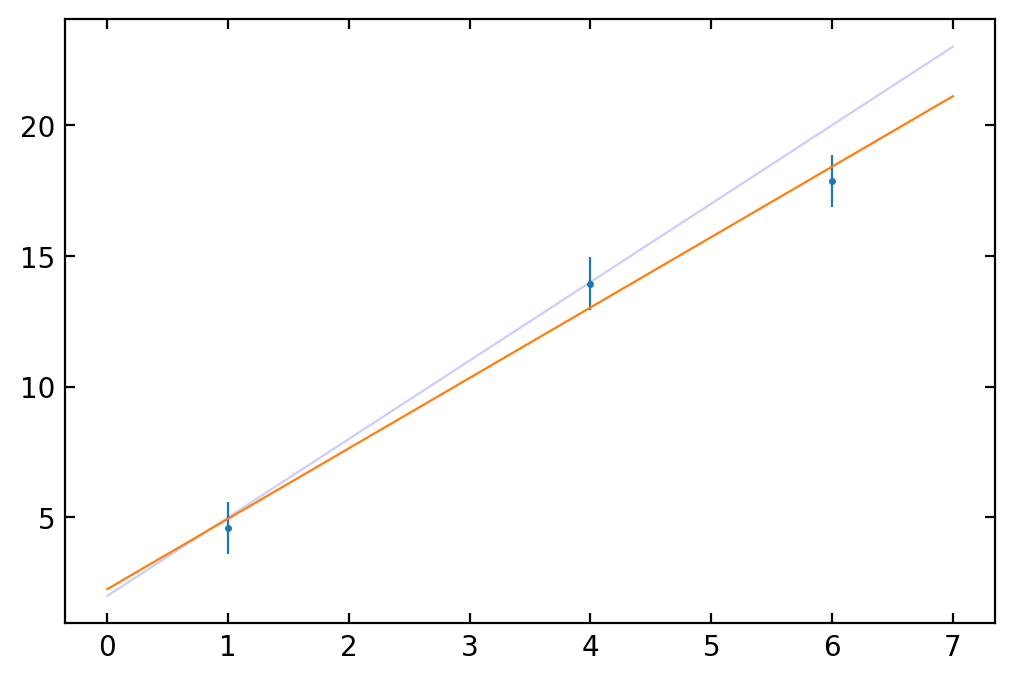

In [61]:
np.random.seed(2)
def func(x):
    return 3*x + 2

err = 1
x = np.array([1, 4, 6])
y = func(x) + norm.rvs(size=len(x), loc=0, scale=err)

x_w_bias = h.add_bias_col(x)

res, _, _, _ = np.linalg.lstsq(x_w_bias, y, rcond=None)


test_x = np.linspace(0, 7, num=100)

_, ax = plt.subplots()
ax.errorbar(x, y, yerr=err, ls="", marker=".")
ax.plot(test_x, func(test_x), color="b", alpha=0.2)

ax.plot(test_x, np.dot(h.add_bias_col(test_x), res))

Look at that. It is beautiful. I guess we are done here.

Well... What if it isn't linear?

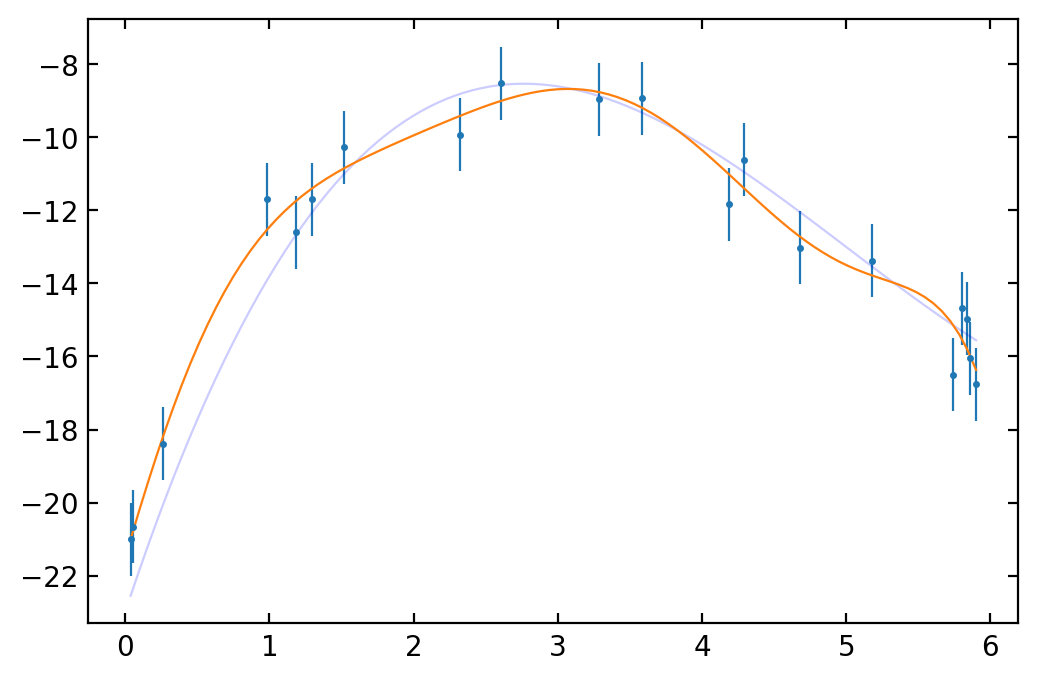

In [117]:
np.random.seed(4)
def func(x):
    return 0.2*(x-5)**3 - 3*x + 2

def build_polynomial_exp(x_orig):
    # Add all the powers of x up to 10.
    # Let's assume we know that our polynomial is < 5
    x = np.expand_dims(x_orig, 1)
    for i in range(2, 8):
        x = np.concatenate((x, np.expand_dims(np.power(x_orig, i), 1)), axis=1)
    x = np.concatenate((x, np.ones((len(x), 1))), axis=1)
    return x

err = 1
x_orig = np.random.random(size = 20) * 6
y = func(x_orig) + norm.rvs(size=len(x_orig), loc=0, scale=err)

x_w_poly_and_bias = build_polynomial_exp(x_orig)

res, _, _, _ = np.linalg.lstsq(x_w_poly_and_bias, y, rcond=None)

test_x = np.linspace(np.min(x_orig), np.max(x_orig), num=100)

_, ax = plt.subplots()
ax.errorbar(x_orig, y, yerr=err, ls="", marker=".")
ax.plot(test_x, func(test_x), color="b", alpha=0.2)

ax.plot(test_x, np.dot(build_polynomial_exp(test_x), res))

Ok not bad! We can fit pretty arbitrary polynomial functions. But what about uncertainties? Grad student me knows that 99% of the problem is quantifying how well we know something.
This method unfortunately doesn't really give us that. We can give a chi squared which shows how well we fit the data. But that just tells us how well we fit the data!
What we really want to know is, when our model predicts y, how confident are we that the truth is within dy of y?

# Bayesian fitting